In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from copy import deepcopy
from typing import Iterable, List, Set, Dict
from itertools import chain

In [2]:
class Hierarchy(object):
    def __init__(
        self,
        C: Iterable,
        C_alternative_names: Iterable,
        C_comps: pd.DataFrame,
        EL_comps: Dict,
    ) -> None:

        """
        @params
        C_comps - upper-level alternatives prevailance coefficients, for each pair of  connected
        criterions contains the matrix of the dependency between alternatives with fixed alternative
        of the left-hand criterion (together C_i-C_j forall x_p of C_i contains M from Mat(n_j, n_j));

        EL_comps - lower-level criterions prevailance coefficients;

        C_alternative_names - names of the alternatives, contained for each cluster;

        """

        self.C = C
        self.C_alternative_names = C_alternative_names

        self.C_comps = C_comps
        self.EL_comps = EL_comps

        self.A = None

        self.__EM()
        self.__form_matrix()

    def __form_matrix(self) -> pd.DataFrame:
        """form the matrix of kind C_i by rows and C_j by columns"""
        eps = 1e-10
        n = len(self.C)

        self.WWE = np.block(
            [
                [
                    self.EL_weights[(C_i, C_j)].values * self.C_weights.loc[C_i]
                    for C_j in self.C
                ]
                for C_i in self.C
            ]
        )
        self.WWE /= (self.WWE + eps).sum(axis=0)
        self.WWE = pd.DataFrame(
            self.WWE,
            columns=list(chain(*list(C_names.values()))),
            index=list(chain(*list(C_names.values()))),
        )

        return self.WWE

    def get_weights(self, k: int) -> pd.DataFrame:

        self.weights = np.linalg.matrix_power(self.WWE, k)
        self.weights = pd.DataFrame(
            self.weights, columns=self.WWE.columns, index=self.WWE.index
        )
        return self.weights

    def get_global_weights(self, columns: Iterable) -> pd.DataFrame:
        global_weights = self.weights.loc[self.weights.index.isin(columns), columns[0]]
        global_weights /= global_weights.sum()
        return global_weights

    def __EM(self) -> np.ndarray:
        def local_EM(data):
            eps = 1e-9
            n = data.shape[0]

            index = np.argmax(np.real(np.linalg.eig(data)[0]))
            weights = np.real(np.linalg.eig(data)[1][:, index])

            weights = weights / weights.sum()
            print(weights)

            return weights

        self.EL_weights = {
            (C_i, C_j): pd.DataFrame(
                {
                    alternative: local_EM(self.EL_comps[(C_j, C_i, alternative)])
                    if (C_j, C_i, alternative) in self.EL_comps
                    and self.C_comps.loc[C_i, C_j] != 0
                    else np.zeros(len(self.C_alternative_names[C_i]))
                    for alternative in self.C_alternative_names[C_j]
                },
                index=self.C_alternative_names[C_i],
            )
            for C_i in self.C
            for C_j in self.C
        }

        # print(self.EL_weights)

        self.C_weights = pd.Series(local_EM(self.C_comps.values), index=self.C)

        return self.EL_weights

    def calculate_limit_weights(self, iters):
        pass


In [3]:
n = 3
C = ['C_1', 'C_2']
C_names = {'C_1': ['x', 'y', 'z'], 'C_2': ['a', 'b', 'c', 'd']}
elements = list(range(n))

#EL_comps = pd.DataFrame(
#    data=np.ones((n ** n, n)),
#    index=pd.MultiIndex.from_product([C, C, elements], names=['from', 'to', 'element']),
#    columns=elements
#)

EL_comps = {**{('C_1', 'C_1', C_names['C_1'][i]): np.random.randint(1, 10, size=(3, 3)) for i in range(3)}, 
            **{('C_1', 'C_2', C_names['C_1'][i]): np.random.randint(1, 10, size=(4, 4)) for i in range(3)}, 
            **{('C_2', 'C_1', C_names['C_2'][i]): np.random.randint(1, 10, size=(3, 3)) for i in range(4)},
            **{('C_2', 'C_2', C_names['C_2'][i]): np.random.randint(1, 10, size=(4, 4)) for i in range(4)}}

C_comps = pd.DataFrame(np.array([[1, 0], [0, 1]]), index=C, columns=C)

In [4]:
C = ['criterions', 'alternatives']
C_names = {'criterions': ['price', 'costs', 'durability'], 'alternatives': ['A', 'EU', 'J']}
C_comps = pd.DataFrame(np.array([[0, 1], [1, 0]]), index=C, columns=C)

EL_comps = {('criterions', 'alternatives', 'price'): np.array([[1, 5, 3], [0.2, 1, 1./3], [1./3, 3, 1]]),
           ('criterions', 'alternatives', 'costs'): np.array([[1, 5, 2], [0.2, 1, 1./3], [1./2, 3, 1]]),
           ('criterions', 'alternatives', 'durability'): np.array([[1, 1./5, 1./3], [5, 1, 3], [3, 1./3, 1]]),
           ('alternatives', 'criterions', 'A'): np.array([[1, 3, 4], [1./3, 1, 1], [1./4, 1, 1]]),
           ('alternatives', 'criterions', 'EU'): np.array([[1, 1, 1./2], [1, 1, 1./2], [2, 2, 1]]),
           ('alternatives', 'criterions', 'J'): np.array([[1, 2, 1], [1./2, 1, 1./2], [1, 2, 1]]),
           ('criterions', 'criterions', 'price'): np.random.randint(5, size=(3, 3)),
           ('criterions', 'criterions', 'costs'): np.random.randint(5, size=(3, 3)),
           ('criterions', 'criterions', 'durability'): np.random.randint(5, size=(3, 3))}


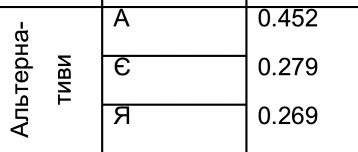

In [5]:
hierarchy = Hierarchy(C, C_names, C_comps, EL_comps)
hierarchy.get_weights(100)
hierarchy.get_global_weights(['A', 'EU', 'J'])

[ 3.00920271+0.j       -0.00460136+0.166348j -0.00460136-0.166348j]
[0.63370792 0.19192062 0.17437146]
[ 3.00000000e+00  6.16297582e-33 -7.50963641e-17]
[0.25 0.25 0.5 ]
[ 3.00000000e+00  6.16297582e-33 -7.50963641e-17]
[0.4 0.2 0.4]
[ 3.03851109+0.j         -0.01925555+0.34153419j -0.01925555-0.34153419j]
[0.63698557 0.10472943 0.25828499]
[ 3.00369460e+00+0.j         -1.84729903e-03+0.10532821j
 -1.84729903e-03-0.10532821j]
[0.58155207 0.10945229 0.30899564]
[ 3.03851109+0.j         -0.01925555+0.34153419j -0.01925555-0.34153419j]
[0.10472943 0.63698557 0.25828499]
[ 1. -1.]
[0.5 0.5]


A     0.451823
EU    0.279227
J     0.268950
Name: A, dtype: float64

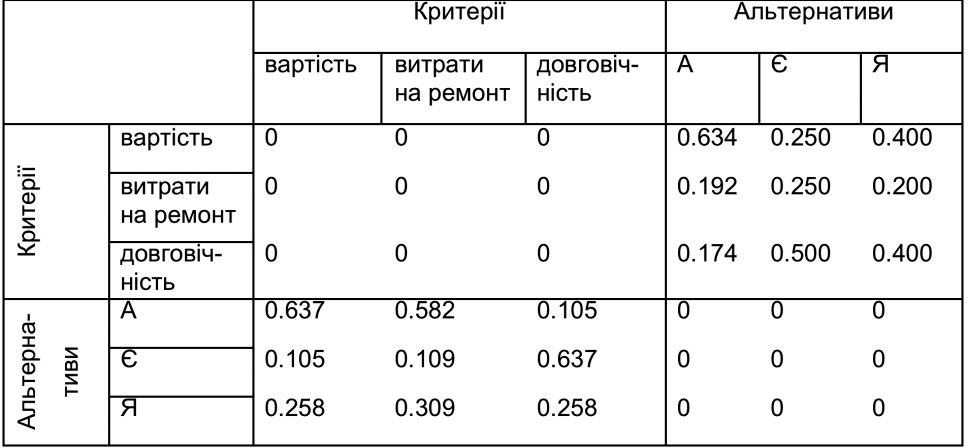

In [6]:
hierarchy.WWE

,price,costs,durability,A,EU,J
price,0.000000,0.000000,0.000000,0.633708,0.25,0.4
costs,0.000000,0.000000,0.000000,0.191921,0.25,0.2
durability,0.000000,0.000000,0.000000,0.174371,0.50,0.4
A,0.636986,0.581552,0.104729,0.000000,0.00,0.0
EU,0.104729,0.109452,0.636986,0.000000,0.00,0.0
J,0.258285,0.308996,0.258285,0.000000,0.00,0.0


In [7]:
row = np.array([1 - 1. / (i * np.log(i + 1)) for i in range(2, 100000)])

In [8]:
np.prod(row)

0.04668873942949312

In [9]:
eps = 1e-1
1 - eps, np.exp(-2 * eps)

(0.9, 0.8187307530779818)

In [10]:
(row > (1. / (row + 1) ** (2 * row))).sum()

99997

In [11]:
np.arange(6) ** np.arange(6)

array([   1,    1,    4,   27,  256, 3125], dtype=int32)

In [12]:
A = np.array([[1, 5, 3], [0.2, 1, 1./3], [1./3, 3, 1]])

In [15]:
np.linalg.e

AttributeError: module 'numpy.linalg' has no attribute 'e'